# Datahåndtering IV: Maskinlæring

```{admonition} Læringsutbytte
Etter å ha arbeidet med dette temaet, skal du kunne:
1. gjør rede for hva som menes med maskinlæring
2. lage, teste og evaluere enkle modeller ved hjelp av maskinlæring
```

Når et barn har sett en hund som har blitt omtalt som en hund, generaliserer det ofte slik at det oppfatter alle dyr som hund. Men ettersom barnet ser flere ulike hunder og andre dyr, klarer det etter hvert å skille hund som en egen kategori. Vi danner oss forestillinger og generaliseringer basert på observasjoner i virkeligheten. Dette kalles _induksjon_. Slutningene vi tar, følger ikke med nødvendighet, men med sannsynlighet. Og ganske ofte kan vi ta feil. Men desto flere uttrykk vi utsettes for, desto større sannsynlighet er det som regel at vi har rett.

Vi kan bruke induktiv læring på datamaskinen også. Da kaller vi det _maskinlæring_. Med de store mengdene digitale data vi omgir oss med, kan datamaskinen lære og trekke slutninger om verden rundt oss. Så istedenfor å eksplisitt kode alle valg en datamaskin kan ta, lar vi datamaskinen lære fra data og trekke slutninger selv.

I dette kapitlet skal vi se på hvordan vi kan benytte biblioteket _scikit-learn_ og _keras_, som er en del av _tensorflow_. Disse bibliotekene må installeres først – du kan skrive for eksempel _pip install scikit-learn tensorflow_ i et terminalvindu for å gjøre dette. Bibliotekene fungerer svært godt sammen med Pandas med Jupyter Notebook som programmeringsplattform, så vi kommer til å benytte dette her.

Vi vender atter tilbake til pingvinene våre. Vi skal her lage en maskinlæringsmodell for å artsbestemme ringpingviner, bøylepingviner og adeliepingviner.

<img src="https://www.uio.no/studier/emner/matnat/ifi/IN-KJM1900/h21/diverse/pingviner.png" width="500"/>
<img src="https://www.uio.no/studier/emner/matnat/ifi/IN-KJM1900/h21/diverse/pingvin.png" width="500"/>


## Steg 1: Les av og utforsk dataene

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pingvindata = pd.read_csv("data/penguins.txt", delimiter = ",")
pingvindata.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Når vi har lest inn fila, kan det være lurt å visualisere ulike sammenhenger i datasettet. Vi skal bestemme oss for hvilke _kriterier_ eller _attributter_ ("features") vi ønsker å legge til grunn for å plassere pingvinen i en eller kategori ("label"). Vi velger her å lage en modell som skal forutsi hvilken pingvinart vi har med å gjøre gitt bestemte verdier av et utvalg variabler. Her er det nyttig å visualisere sammenhenger slik at du har en formening om hvilke kategorier som er mest egnet til en bestemmelsesnøkkel.

```{admonition} Underveisoppgave
:class: tip
Bruk pairplot-funksjonen til seaborn-biblioteket til å lage noen hypoteser på hvilke kriterier som er mest avgjørende for å bestemme hva slags art vi har med å gjøre.
```

Siden det mangler noen verdier (NaN), må vi gjøre noe med dem. Enten kan vi bytte dem ut med for eksempel medianverdien eller gjennomsnittet, eller så kan vi fjerne alle pingvinene med NaN-verdier. Sistnevnte er ganske drastisk, men går ofte greit dersom datasettet er stort. Vi gjør det slik for enkelhets skyld:

In [18]:
pingvindata.dropna(inplace=True)

## Steg 2: Velge treningssett og testsett
For å lage en modell som skal forutsi pingvinarten, må vi først importere noen nyttige funksjoner fra scikit-learn-biblioteket. Vi skal gradvis se hva disse funksjonene gjør.

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

Nå er vi klare for litt maskinlæring. Grunnprinsippene er som følger:
1. Bestem hvilke kriterier som skal ligge til grunn for kategorien vi ønskerat maskinlæringsalgoritmen skal sortere etter.
2. Velg ut en del av datasettet som datamaskinen skaltrenepå og en avdatasettet vi skaltestemed til slutt. Datamaskinen ser på kriteriene ogde tilhørende kategoriene, og bestemmer en sannsynlighet for sammen-hengen mellom ulike kriterier og kategorier.
3. Lag en modell. Dette gjør vi ved å bruke ferdige algoritmer fra et ma-skinlæringsbibliotek.
4. Tren modellen med treningssettet. Nå har du lagd en modell som ertilpasset det vi ønsket.
5. Valider modellen ved å bruke testsettet.
6. Analyser modellen og gjør eventuelle endringer slik at forutsigelsene mo-dellen gjør, blir så gode som mulig

Først velger vi altså ut kriterier og bestemmer kategorier. La oss bare begynne med to kriterier: nebblengde og nebbdybde.

In [19]:
kriterier = pingvindata[['bill_length_mm', 'bill_depth_mm']] # features
kategorier = pingvindata['species']                          # labels

Legg merke til at det er dobbel klammeparentes i første linje. Dette gir et objekt med to kolonner. Maskinlæringsalgoritmene krever et objekt (en array eller dataramme) som består av både kolonner og rader, derfor er disse doble klammeparentesene alltid nødvendig.

La oss nå velge ut hvor stor andel av datasettet vi skal trene med. Det er ofte lurt å trene med 70–80 \% av datasettet, og bruke resten til å teste med. Det finnes en funksjon som gjør dette automatisk, nemlig _train\_test\_split_:

In [20]:
# Velge ut data til trening og testing
treningsandel = 0.8 # Velger 80 prosent av datasettet til trening
ml_data = train_test_split(kriterier, kategorier, train_size=treningsandel, random_state=42)

treningskriterier = ml_data[0]
testkriterier = ml_data[1]
treningskategorier = ml_data[2]
testkategorier = ml_data[3]

Det funksjonen ovenfor gjør, er å velge ut 80 \% av dataene fra tilfeldige steder i datasettet til trening og 20 \% til testing. Vi lagrer kriterier (lengden og dypbden til pingvinnebbet) og tilsvarende kategori (art) i variabelen _ml\_data_. Denne består nå av fire separate elementer, som vi sorterer i linjene nederst i fire ulike variabler: kategorielementene (altså verdien til nebbdybde og nebblengde) og de tilsvarende kategoriene (hvilken art det tilsvarer) som ble valgt ut til trening, og tilsvarende for testing.

En litt merkelig parameter er _random\_state_. Den er ikke nødvendig for å dele opp datasettet, men den er nyttig. Hvis vi velger et tilfeldig tall her, låser vi algoritmen slik at den plukker ut de samme tallene hver gang vi kjører programmet. Det kan være en fordel dersom vi ønsker å teste og tilpasse modellen, men ønsker å ha det samme utvalget av datasettet hver gang. Hvis vi ikke velger et fast utvalg, vil modellen gi ulike resultater hver gang vi kjører programmet.

```{admonition} Underveisoppgave
Skriv ut de ulike kategoriene og kriteriene for å se hva programmet har generert så langt. Prøv å bytte ut eller fjerne random\_state-parameteren og kjør programmet flere ganger. Observer hva som skjer.

<iframe src="https://trinket.io/embed/python3/4b0941cd4e" width="100%" height="500" frameborder="0" marginwidth="0" marginheight="0" allowfullscreen></iframe>
```

## Steg 3: Lag modellen
Nå kan vi velge en algoritme som grunnlag for modellen vår. Det finnes mange ulike algoritmer, og de benytter statistikk og lineær algebra til å optimere ulike parametre. Vi skal ikke se på algoritmene her, men heller fokusere på å forstå hvordan de fungerer. Derfor starter vi med en enkel beslutningstrealgoritme. Denne fungerer som et slags valgtre, der hvert valg utføres fra et gitt kriterium (for eksempel nebblengde mindre enn 40 mm), og som brukes til å sannsynliggjøre hvilken art vi har med å gjøre.

Vi lager og trener modellen slik:

In [21]:
modell = tree.DecisionTreeClassifier()                  # Lager modellen
modell.fit(treningskriterier, treningskategorier)       # Trener modellen

DecisionTreeClassifier()

Nå har vi (eller datamaskinen) faktisk lagd modellen vår, og vi har brukt treningsdataene til å trene modellen slik at den best mulig kan forutsi kategorier basert på gitte kriterier.

## Steg 4: Test og evaluer modellen
Vi skal nå teste og evaluere modellen vår:

In [22]:
forutsigelser = modell.predict(testkriterier)
accuracy_score(testkategorier, forutsigelser)

0.9402985074626866

Her bruker vi altså testkriteriene og lar modellen forutsi hvilke kategorier dette tilsvarer (forutsigelser). Så sammenlikner vi dette med de faktiske kategoriene (testkategorier) med funksjonen \texttt{accuracy\_score}. I dette tilfellet får vi en treffsikkerhet på ca. 94 \%. Det betyr at modellen vår gir riktig pingvinart 94 \% av gangene. Det er ikke verst!

Vi kan også bruke modellen til å forutsi en art gitt helt nye data, for eksempel slik:

In [26]:
nebblengde = 35
nebbdybde = 15
modell.predict([[nebblengde, nebbdybde]]) # Husk to klammer her!

array(['Adelie'], dtype=object)

Dette betyr at en pingvin med nebblengde 35 mm og nebbdybde 15 mm mest sannsynlig er en Adelie-pingvin.

## Steg 5: Videre analyse
Noen ganger blir modellen ganske dårlig, og da kan det hende du bør gå tilbake og velge andre, eller flere attributter (kriterier) for modellen. For å analysere videre hva modellen feiler på, kan det være fint å lage en forvirringsmatrise(også kalt feilmatrise). Tallene for forvirringsmatrisen kan vi lage med en funksjon som heter _confusion\_matrix_, og selve matrisen kan vi lage med heatmap-funksjonen til seaborn-biblioteket:

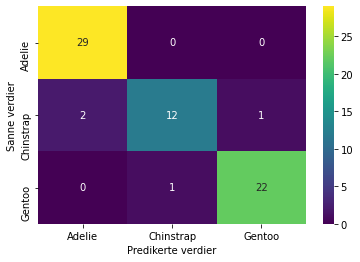

In [34]:
cm = confusion_matrix(forutsigelser, testkategorier)
sns.heatmap(cm, annot=True, cmap="viridis",
           xticklabels=["Adelie", "Chinstrap", "Gentoo"], yticklabels=["Adelie", "Chinstrap", "Gentoo"])
plt.xlabel("Predikerte verdier")
plt.ylabel("Sanne verdier")
plt.savefig("forvirringsmatrise.pdf", dpi = 600)

Hvis vi ikke benytter _ticklabels_, får vi verdiene 0, 1 og 2, som vi selv må tolke som de ulike artskategoriene etter rekkefølgen de har i datasettet. 

Totalt har vi brukt 20 \% av datasettets 333 datapunkter til testing, det vil si 67 datapunkter. Matrisen sammenlikner de predikerte kategoriene og de sanne testkategoriene. Vi kan se at den for eksempel forutså at arten tilhørte Adelie 29 riktige ganger, men forutså Chinstrap (ringpingvin) én gang der arten skulle vært Gentoo (bøylepingvin).

Maskinlæring kan brukes til ufattelig mye rart, og det finnes mange ulike modeller som man kan prøve ut. Her var hovedpoenget å bli litt kjent med hva maskinlæring er og hvor enkelt det er å utføre enkel maskinlæring med dagens verktøy.